In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
drive_base = '/content/drive/MyDrive'
train_dir = os.path.join(drive_base, 'Meat Freshness.v1-new-dataset.multiclass/train')
valid_dir = os.path.join(drive_base, 'Meat Freshness.v1-new-dataset.multiclass/valid')
train_csv = os.path.join(train_dir, '_classes.csv')
valid_csv = os.path.join(valid_dir, '_classes.csv')

train_df = pd.read_csv(train_csv)
valid_df = pd.read_csv(valid_csv)

train_df.columns = train_df.columns.str.strip()
valid_df.columns = valid_df.columns.str.strip()

train_df['filename'] = train_df['filename'].apply(lambda x: os.path.join(train_dir, x))
valid_df['filename'] = valid_df['filename'].apply(lambda x: os.path.join(valid_dir, x))

train_df['label'] = train_df[['Fresh', 'Half-Fresh', 'Spoiled']].idxmax(axis=1)
valid_df['label'] = valid_df[['Fresh', 'Half-Fresh', 'Spoiled']].idxmax(axis=1)

In [ ]:
train_counts = train_df['label'].value_counts()
valid_counts = valid_df['label'].value_counts()
print('Training set class distribution:')
print(train_counts)
print('\nValidation set class distribution:')
print(valid_counts)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Create ImageDataGenerators with data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Ensure validation data order is consistent
)

Mounted at /content/drive
Training set class distribution:
label
Fresh         675
Half-Fresh    630
Spoiled       510
Name: count, dtype: int64

Validation set class distribution:
label
Fresh         178
Half-Fresh    159
Spoiled       114
Name: count, dtype: int64
Found 1815 validated image filenames belonging to 3 classes.
Found 451 validated image filenames belonging to 3 classes.
16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/20
57/57 [==============================] - 824s 14s/step - loss: 1.1314 - accuracy: 0.3504 - val_loss: 1.1026 - val_accuracy: 0.2528 - lr: 1.0000e-05
Epoch 2/20
57/57 [==============================] - 536s 9s/step - loss: 1.0132 - accuracy: 0.4821 - val_loss: 1.1012 - val_accuracy: 0.2528 - lr: 1.0000e-05
Epoch 3/20
57/57 [==============================] - 538s 9s/step - loss: 0.9188 - accuracy: 0.5543 - val_loss: 1.1106 - val_accuracy: 0.1907 - lr: 1.0000e-05
Epoch 4/20
57/57 [==============================] - 547s 10s/step - loss

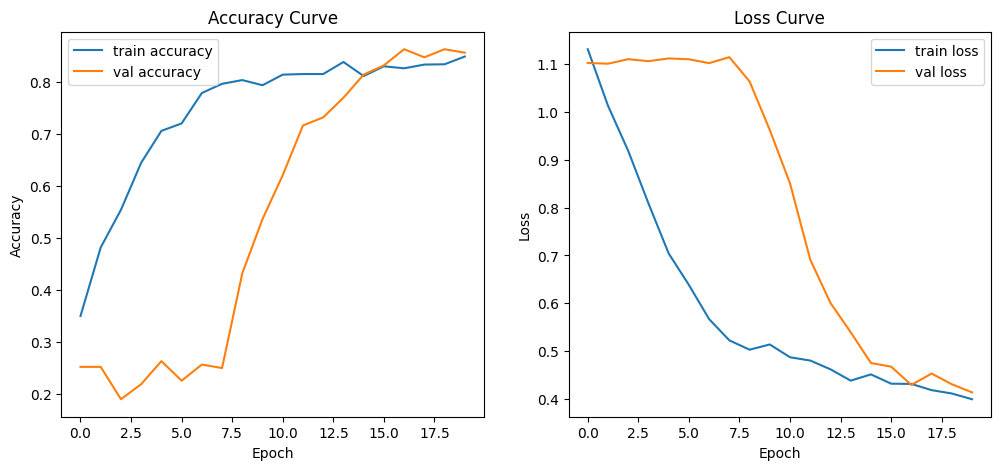

15/15 [==============================] - 38s 2s/step


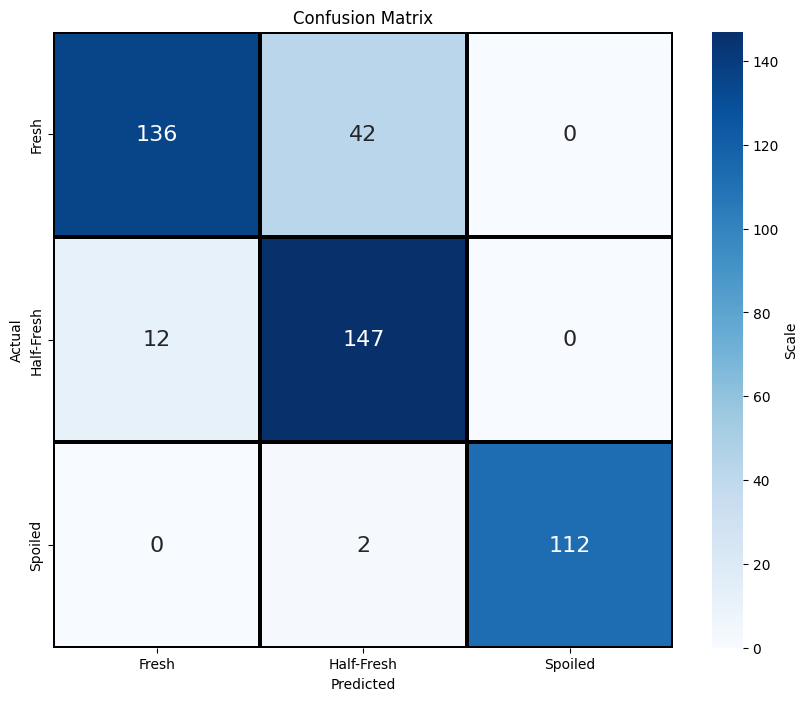

Classification Report:
              precision    recall  f1-score   support

       Fresh       0.92      0.76      0.83       178
  Half-Fresh       0.77      0.92      0.84       159
     Spoiled       1.00      0.98      0.99       114

    accuracy                           0.88       451
   macro avg       0.90      0.89      0.89       451
weighted avg       0.89      0.88      0.88       451



In [ ]:
# Load EfficientNet model
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# Unfreeze more layers of the base model
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

train_accuracies = history.history['accuracy']
val_accuracies = history.history['val_accuracy']
train_losses = history.history['loss']
val_losses = history.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='train accuracy')
plt.plot(val_accuracies, label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.show()

y_pred = model.predict(valid_generator)
y_pred_classes = y_pred.argmax(axis=-1)
y_true = valid_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys(), cbar_kws={'label': 'Scale'}, annot_kws={"size": 16}, linewidths=1.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_true, y_pred_classes, target_names=valid_generator.class_indices.keys())
print('Classification Report:')
print(class_report)